### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Set visual style for plots
sns.set(style="whitegrid")

function for downcasting, and we will need for optimization

In [3]:
def downcaste_dtype(df):
    previous_memory_consumption = (df.memory_usage().sum()) / 1024**2
    for col in df.columns:
        col_dtype = df[col].dtypes
        if col_dtype != 'object':
            xmin = df[col].min()
            xmax = df[col].max()
            if str(col_dtype)[0] == 'i':
                if np.iinfo('int8').min < xmin and np.iinfo('int8').max > xmax:
                    df[col] = df[col].astype('int8')
                elif np.iinfo('int16').min < xmin and np.iinfo('int16').max > xmax:
                    df[col] = df[col].astype('int16')
                elif np.iinfo('int32').min < xmin and np.iinfo('int32').max > xmax:
                    df[col] = df[col].astype('int32')
                elif np.iinfo('int64').min < xmin and np.iinfo('int64').max > xmax:
                    df[col] = df[col].astype('int64')

            elif str(col_dtype)[0] == 'f':
                if np.finfo('float16').min < xmin and np.finfo('float16').max > xmax:
                    df[col] = df[col].astype('float16')
                elif np.finfo('float32').min < xmin and np.finfo('float32').max > xmax:
                    df[col] = df[col].astype('float32')
                elif np.finfo('float64').min < xmin and np.finfo('float64').max > xmax:
                    df[col] = df[col].astype('float64')
            else:
                pass

    after_memory_consumption = (df.memory_usage().sum()) / 1024**2
    percentage_of_decrease = ((previous_memory_consumption - after_memory_consumption) / previous_memory_consumption) * 100

    print('Memory usage before downcasting: {:.2f} MB'.format(previous_memory_consumption))
    print('After Downcasting the memory usage decreased to: {:.2f} MB'.format(after_memory_consumption))
    print('Memory usage decreased by {:.3f}%'.format(percentage_of_decrease))

    return df

### Loading Data

In [4]:
loan_applications = pd.read_csv('../DataSet/loan_applications_train.csv')
previous_credits = pd.read_csv('../DataSet/previous_credits.csv')
credit_bureau_balance = pd.read_csv('../DataSet/credit_bureau_balance.csv')
previous_loan_applications = pd.read_csv('../DataSet/previous_loan_applications.csv')
repayment_history = pd.read_csv('../DataSet/repayment_history.csv')
pos_cash_loans = pd.read_csv('../DataSet/previous_pos_cash_loans.csv')
credit_cards = pd.read_csv('../DataSet/previous_credit_cards.csv')

In [5]:
# optimizing
loan_applications = downcaste_dtype(loan_applications)
previous_credits = downcaste_dtype(previous_credits)
credit_bureau_balance = downcaste_dtype(credit_bureau_balance)
previous_loan_applications = downcaste_dtype(previous_loan_applications)
repayment_history = downcaste_dtype(repayment_history)
pos_cash_loans = downcaste_dtype(pos_cash_loans)
credit_cards = downcaste_dtype(credit_cards)

Memory usage before downcasting: 286.23 MB
After Downcasting the memory usage decreased to: 92.38 MB
Memory usage decreased by 67.725%
Memory usage before downcasting: 222.62 MB
After Downcasting the memory usage decreased to: 112.95 MB
Memory usage decreased by 49.265%
Memory usage before downcasting: 624.85 MB
After Downcasting the memory usage decreased to: 338.46 MB
Memory usage decreased by 45.833%
Memory usage before downcasting: 471.48 MB
After Downcasting the memory usage decreased to: 309.01 MB
Memory usage decreased by 34.459%
Memory usage before downcasting: 830.41 MB
After Downcasting the memory usage decreased to: 311.40 MB
Memory usage decreased by 62.500%
Memory usage before downcasting: 610.43 MB
After Downcasting the memory usage decreased to: 238.45 MB
Memory usage decreased by 60.937%
Memory usage before downcasting: 673.88 MB
After Downcasting the memory usage decreased to: 289.33 MB
Memory usage decreased by 57.065%


# EDA, Data Cleaning and Feature Engineering

# 1. Applicant Profile Section

Summary statistics

In [6]:
# summary = loan_applications.describe()

Distribution of key numerical features

In [7]:
# loan_applications.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

Pair Plot for selected features

In [8]:
# selected_features = ['amt_income_total', 'amt_credit', 'amt_annuity']
# sns.pairplot(loan_applications[selected_features])
# plt.suptitle('Pairwise Plots of Key Features')

Gender distribution

In [9]:
# plt.figure(figsize=(8, 5))
# sns.countplot(x='code_gender', data=loan_applications)
# plt.title('Gender Distribution')

Income distribution (with log transformation for better visualization)

In [10]:
# plt.figure(figsize=(8, 5))
# sns.distplot(np.log1p(loan_applications['amt_income_total']), kde=False)
# plt.title('Log Transformed Income Distribution')
# plt.xlabel('Log of Total Income')
# plt.ylabel('Frequency')

Boxplot for income by gender

In [11]:
# plt.figure(figsize=(8, 5))
# sns.boxplot(x='code_gender', y='amt_income_total', data=loan_applications)
# plt.title('Income Distribution by Gender')

Correlation analysis with heatmap

In [12]:
# correlation_matrix = loan_applications.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')

Income vs Loan Amount with Hue for Contract Type

In [13]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='amt_income_total', y='amt_credit', hue='name_contract_type', data=loan_applications)
# plt.title('Income vs Loan Amount by Contract Type')
# plt.xlabel('Total Income')
# plt.ylabel('Credit Amount')

Average income by contract type

In [14]:
avg_income_by_contract = loan_applications.groupby('name_contract_type')['amt_income_total'].mean()

KDE Plot of Age for different Contract Types

In [15]:
# plt.figure(figsize=(10, 6))
# for contract_type in loan_applications['name_contract_type'].unique():
#     subset = loan_applications[loan_applications['name_contract_type'] == contract_type]
#     sns.kdeplot(subset['age_years'], label=contract_type)
# plt.title('Age Distribution by Contract Type')
# plt.xlabel('Age in Years')
# plt.ylabel('Density')

Z-Score for Income, for outlier detection

In [16]:
# loan_applications['income_z_score'] = np.abs(stats.zscore(loan_applications['amt_income_total']))
# outliers = loan_applications[loan_applications['income_z_score'] > 3]
# outliers

##### Data Cleaning and Feature Engineering

In [17]:
# Using SimpleImputer
imputer = SimpleImputer(strategy='mean')
numerical_cols = loan_applications.select_dtypes(include=[np.number]).columns
loan_applications[numerical_cols] = imputer.fit_transform(loan_applications[numerical_cols])

In [18]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [19]:
# Handling missing values for categorical columns with mode imputation
categorical_cols = loan_applications.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    loan_applications[col].fillna(loan_applications[col].mode()[0], inplace=True)

In [20]:
# Feature Engineering

# Income Ratios
loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
loan_applications['goods_price_income_ratio'] = loan_applications['amt_goods_price'] / loan_applications['amt_income_total']

# Career Ratio
loan_applications['employment_ratio'] = loan_applications['days_employed'] / loan_applications['days_birth']
loan_applications['employment_ratio'] = loan_applications['employment_ratio'].replace([np.inf, -np.inf], np.nan)

# Family Features
loan_applications['adults_ratio'] = (loan_applications['cnt_fam_members'] - loan_applications['cnt_children']) / loan_applications['cnt_fam_members']

# Number of Overall Payments
loan_applications['payment_rate'] = loan_applications['amt_credit'] / loan_applications['amt_annuity'].replace({0: np.nan})

# External Source Features
loan_applications['ext_sources_mean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].mean(axis=1)
loan_applications['ext_sources_nanmean'] = loan_applications[['ext_source_1', 'ext_source_2', 'ext_source_3']].apply(lambda x: np.nanmean(x), axis=1)

# Number of Documents Submitted
doc_vars = ["flag_document_" + str(i) for i in range(2, 22)]
loan_applications['doc_count'] = loan_applications[doc_vars].sum(axis=1)

# Logarithm Transformation of Skewed Features
skewed_cols = ['amt_credit', 'amt_income_total', 'amt_goods_price', 'amt_annuity']
for col in skewed_cols:
    loan_applications['log_' + col] = np.log1p(loan_applications[col])

# Convert Days to Years
days_cols = ['days_birth', 'days_employed', 'days_registration', 'days_id_publish', 'days_last_phone_change']
for col in days_cols:
    loan_applications[col + '_years'] = np.abs(loan_applications[col]) / 365

# Age-Related Ratios
loan_applications['car_age_ratio'] = loan_applications['own_car_age'] / loan_applications['days_birth']
loan_applications['phone_change_ratio'] = loan_applications['days_last_phone_change'] / loan_applications['days_birth']


C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_2808\784934114.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_applications['credit_income_ratio'] = loan_applications['amt_credit'] / loan_applications['amt_income_total']
C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_2808\784934114.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  loan_applications['annuity_income_ratio'] = loan_applications['amt_annuity'] / loan_applications['amt_income_total']
C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_2808\784934114.

In [21]:
# One-Hot Encoding for categorical variables
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_features = ohe.fit_transform(loan_applications[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))
loan_applications = loan_applications.drop(columns=categorical_cols).join(encoded_features_df)

In [22]:
# Winsorization to cap outliers
for col in numerical_cols:
    loan_applications[col] = winsorize(loan_applications[col], limits=[0.05, 0.05])

In [23]:
# important_features = loan_applications.columns.drop('target')
# # Feature Selection using RandomForest (Assuming a target variable exists)
# rf = RandomForestClassifier(n_estimators=100, random_state=42)
# rf.fit(loan_applications[important_features], loan_applications['target'])
# importances = rf.feature_importances_
# important_features = [feature for feature, importance in zip(important_features, importances) if importance > np.mean(importances)]

In [24]:
# # Final dataset with selected important features
# loan_applications = loan_applications[important_features + ['target']]

# # Display the first few rows of the processed dataset
# loan_applications

In [25]:
loan_applications.isnull().sum().sum()

0

# 2. Credit History Section

In [26]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_cols_prev = previous_credits.select_dtypes(include=[np.number]).columns
previous_credits[numerical_cols_prev] = num_imputer.fit_transform(previous_credits[numerical_cols_prev])

In [27]:
# Handling missing values for categorical columns
categorical_cols = previous_credits.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    previous_credits[col].fillna(previous_credits[col].mode()[0], inplace=True)

In [28]:
# # Distribution of key numerical features for previous_credits
# previous_credits.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

In [29]:
# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')
numerical_cols_bur = credit_bureau_balance.select_dtypes(include=[np.number]).columns
credit_bureau_balance[numerical_cols_bur] = num_imputer.fit_transform(credit_bureau_balance[numerical_cols_bur])

In [30]:
# Handling missing values for categorical columns
categorical_cols = credit_bureau_balance.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    credit_bureau_balance[col].fillna(credit_bureau_balance[col].mode()[0], inplace=True)

In [31]:
# merging data fror this section
cred_histo = pd.merge(previous_credits, credit_bureau_balance, on='sk_id_bureau', how='left')

In [32]:
# # Heatmap for Credit Amount vs. Status
# pivot_table = cred_histo.pivot_table(values='amt_credit_sum', index='credit_active', columns='status', aggfunc='mean')
# plt.figure(figsize=(10, 6))
# sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
# plt.title('Average Credit Amount by Credit Status and Activity')

In [33]:
# # Correlation analysis
# correlation_matrix = cred_histo.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')

In [34]:
# Average credit amount by credit type
avg_credit_by_type = cred_histo.groupby('credit_type')['amt_credit_sum'].mean()

# Total credit amount by credit active status
total_credit_by_status = cred_histo.groupby('credit_active')['amt_credit_sum'].sum()

# Count of credits by credit type and active status
count_credits = cred_histo.groupby(['credit_type', 'credit_active']).size().reset_index(name='count')

# Average monthly balance by status
avg_monthly_balance_by_status = credit_bureau_balance.groupby('status')['months_balance'].mean()

# Maximum overdue amount in credit bureau data
max_overdue = previous_credits.groupby('sk_id_bureau')['amt_credit_max_overdue'].max()

# Multi-level aggregation
agg_data = previous_credits.groupby('credit_active').agg({'amt_credit_sum': 'mean',
                                                         'amt_credit_max_overdue': 'max'}).reset_index()

In [35]:
# # Bar plot for average credit by type
# plt.figure(figsize=(10, 6))
# sns.barplot(x='credit_type', y='amt_credit_sum', data=avg_credit_by_type.reset_index())
# plt.title('Average Credit Amount by Credit Type')
# plt.xticks(rotation=45)

In [36]:
# # Bar plot for count of credits
# plt.figure(figsize=(12, 6))
# sns.barplot(x='credit_type', y='count', hue='credit_active', data=count_credits)
# plt.title('Count of Credits by Type and Active Status')
# plt.xticks(rotation=45)

In [37]:
# using Z-score for Credit Amount, for outlier detection
cred_histo['credit_amount_z_score'] = np.abs(stats.zscore(cred_histo['amt_credit_sum']))
outliers = cred_histo[cred_histo['credit_amount_z_score'] > 3]

##### Data cleaning and Feature engineering

In [38]:
# # One-Hot Encoding for categorical variables
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
# encoded_features = ohe.fit_transform(cred_histo[categorical_cols])
# encoded_features_df = pd.DataFrame(encoded_features, columns=ohe.get_feature_names_out(categorical_cols))
# cred_histo = cred_histo.drop(columns=categorical_cols).join(encoded_features_df)

In [39]:
# Winsorization to cap outliers in numerical columns
for col in numerical_cols_prev:
    cred_histo[col] = winsorize(cred_histo[col], limits=[0.05, 0.05])

for col in numerical_cols_bur:
    cred_histo[col] = winsorize(cred_histo[col], limits=[0.05, 0.05])

In [40]:
cred_histo.columns

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
       'amt_credit_sum_overdue', 'credit_type', 'days_credit_update',
       'amt_annuity', 'months_balance', 'status', 'credit_amount_z_score'],
      dtype='object')

In [41]:
# Feature Engineering on cred_histo data
# Replace 'X' with None and encode other statuses as increasing integers
cred_histo['status'].replace({'X': None, 'C': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6}, inplace=True)
# Calculate loan score
cred_histo['loan_score'] = cred_histo['status'] / (abs(cred_histo['months_balance']) + 1)
loan_score = cred_histo.groupby('sk_id_bureau')['loan_score'].sum().rename('loan_score').reset_index()

# Merge the loan score into cred_histo
cred_histo = cred_histo.merge(loan_score, on='sk_id_bureau', how='left')

# Encoding categorical 'status' into dummy variables
cred_histo = pd.get_dummies(cred_histo, columns=['status'], prefix='status')

In [42]:
cred_histo.columns

Index(['sk_id_curr', 'sk_id_bureau', 'credit_active', 'credit_currency',
       'days_credit', 'credit_day_overdue', 'days_credit_enddate',
       'days_enddate_fact', 'amt_credit_max_overdue', 'cnt_credit_prolong',
       'amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit',
       'amt_credit_sum_overdue', 'credit_type', 'days_credit_update',
       'amt_annuity', 'months_balance', 'credit_amount_z_score',
       'loan_score_x', 'loan_score_y', 'status_0.0', 'status_1.0',
       'status_2.0', 'status_3.0', 'status_4.0', 'status_5.0', 'status_6.0'],
      dtype='object')

In [43]:


# Aggregate bureau balance data
cred_histo = cred_histo.groupby('sk_id_bureau').agg('mean')
cred_histo['MONTH_COUNT'] = cred_histo.groupby('sk_id_bureau')['months_balance'].count()


# Feature Engineering on cred_histo data
# Amount ratios
cred_histo['AMT_SUM_OVERDUE_RATIO'] = cred_histo['amt_credit_sum_overdue'] / cred_histo['amt_credit_sum']
cred_histo['AMT_MAX_OVERDUE_RATIO'] = cred_histo['amt_credit_max_overdue'] / cred_histo['amt_credit_sum']
cred_histo['AMT_SUM_DEBT_RATIO'] = cred_histo['amt_credit_sum_debt'] / cred_histo['amt_credit_sum']

# Log transformations
log_vars = ['amt_credit_sum', 'amt_credit_sum_debt', 'amt_credit_sum_limit', 'amt_credit_sum_overdue', 'amt_annuity']
for var in log_vars:
    cred_histo['log_' + var] = np.log1p(cred_histo[var])

# Convert days to positive values and years
days_cols = ['days_credit', 'credit_day_overdue', 'days_credit_enddate', 'days_enddate_fact', 'days_credit_update']
for col in days_cols:
    cred_histo[col] = np.abs(cred_histo[col]) / 365

# Detect and handle outliers for 'amt_credit_sum'
z_scores = np.abs(stats.zscore(cred_histo['amt_credit_sum']))
cred_histo['amt_credit_sum'] = np.where(z_scores > 3, cred_histo['amt_credit_sum'].median(), cred_histo['amt_credit_sum'])

# Aggregate features
agg_features = {
    'amt_credit_sum': ['mean', 'sum', 'max'],
    'amt_credit_sum_debt': ['mean', 'sum', 'max'],
    'amt_credit_sum_overdue': ['mean', 'sum', 'max'],
    'amt_annuity': ['mean', 'sum', 'max'],
    'sk_id_curr': ['size']
}

cred_histo = cred_histo.groupby('sk_id_curr').agg(agg_features)
cred_histo.columns = ['_'.join(col).upper() for col in cred_histo.columns.values]


In [44]:
cred_histo.columns

Index(['AMT_CREDIT_SUM_MEAN', 'AMT_CREDIT_SUM_SUM', 'AMT_CREDIT_SUM_MAX',
       'AMT_CREDIT_SUM_DEBT_MEAN', 'AMT_CREDIT_SUM_DEBT_SUM',
       'AMT_CREDIT_SUM_DEBT_MAX', 'AMT_CREDIT_SUM_OVERDUE_MEAN',
       'AMT_CREDIT_SUM_OVERDUE_SUM', 'AMT_CREDIT_SUM_OVERDUE_MAX',
       'AMT_ANNUITY_MEAN', 'AMT_ANNUITY_SUM', 'AMT_ANNUITY_MAX',
       'SK_ID_CURR_SIZE'],
      dtype='object')

In [45]:
loan_applications = loan_applications.merge(right = cred_histo, how="left", on = "sk_id_curr")
del cred_histo

# 3. Bank X loan history section

In [46]:
# bank_loan_hist = pd.merge(previous_loan_applications, repayment_history, on='sk_id_curr', how='inner')

In [47]:
# # Distribution of key numerical features
# bank_loan_hist.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

In [48]:
# #Loan Amount Distribution
# plt.figure(figsize=(10, 6))
# sns.distplot(bank_loan_hist['amt_credit'], bins=30, kde=False)
# plt.title('Distribution of Loan Amounts')

In [49]:
# # Correlation analysis
# correlation_matrix = merged_data.corr()
# plt.figure(figsize=(12, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')

In [50]:
# # Bar plot for average loan amount by status
# plt.figure(figsize=(10, 6))
# sns.barplot(x='name_contract_status', y='amt_credit', data=avg_loan_by_status.reset_index())
# plt.title('Average Loan Amount by Contract Status')
# plt.xticks(rotation=45)

In [51]:
# # Bar plot for total payment by loan type
# plt.figure(figsize=(12, 6))
# sns.barplot(x='name_contract_type', y='amt_payment', data=total_payment_by_type.reset_index())
# plt.title('Total Payment by Loan Type')
# plt.xticks(rotation=45)

In [52]:
# # detecting outliers, using z-score
# bank_loan_hist['loan_amount_z_score'] = np.abs(stats.zscore(bank_loan_hist['amt_credit']))
# outliers = bank_loan_hist[bank_loan_hist['loan_amount_z_score'] > 3]
# outliers

##### Data cleaning and Feature engineering

In [53]:
# Feature Engineering for Repayment History
repayment_history['DPD'] = repayment_history['days_entry_payment'] - repayment_history['days_instalment']
repayment_history['DBD'] = repayment_history['days_instalment'] - repayment_history['days_entry_payment']
repayment_history['DPD'] = repayment_history['DPD'].apply(lambda x: x if x > 0 else 0)
repayment_history['DBD'] = repayment_history['DBD'].apply(lambda x: x if x > 0 else 0)

# Percentage and difference paid in each installment
repayment_history['PAYMENT_PERC'] = repayment_history['amt_payment'] / repayment_history['amt_instalment']
repayment_history['PAYMENT_DIFF'] = repayment_history['amt_instalment'] - repayment_history['amt_payment']

# Logarithmic transformation
repayment_history['log_amt_instalment'] = np.log1p(repayment_history['amt_instalment'])
repayment_history['log_amt_payment'] = np.log1p(repayment_history['amt_payment'])

# Count of installments
inst_count = repayment_history.groupby('sk_id_prev')['num_instalment_number'].nunique().reset_index()
inst_count.rename(columns={'num_instalment_number': 'NUM_INSTALMENT_COUNT'}, inplace=True)

# Merge count of installments back to the repayment history
# Make sure to drop duplicates from inst_count if 'sk_id_prev' is not unique
inst_count = inst_count.drop_duplicates(subset=['sk_id_prev'])
repayment_history = repayment_history.merge(inst_count, on='sk_id_prev', how='left')

#  perform the loan-level aggregation and flatten the MultiIndex columns
agg_repayment_history_loan = repayment_history.groupby('sk_id_prev').agg({
    'DPD': ['mean', 'max'],
    'DBD': ['mean', 'max'],
    'PAYMENT_PERC': ['mean', 'min', 'max'],
    'PAYMENT_DIFF': ['mean', 'sum'],
    'log_amt_instalment': ['mean', 'max'],
    'log_amt_payment': ['mean', 'max'],
}).reset_index()

# Flatten MultiIndex columns
agg_repayment_history_loan.columns = ['_'.join(col).strip() for col in agg_repayment_history_loan.columns.values]

agg_repayment_history_loan.rename(columns={"sk_id_prev_": "sk_id_prev"}, inplace=True)

# Merge with the original loan_applications DataFrame to get 'sk_id_curr'
agg_repayment_history_loan = agg_repayment_history_loan.merge(repayment_history[['sk_id_prev', 'sk_id_curr']], on='sk_id_prev', how='left')

# Now perform customer-level aggregation using the correct column names
agg_repayment_history_customer = agg_repayment_history_loan.groupby('sk_id_curr').agg({
    'DPD_mean': 'mean',
    'DPD_max': 'max',
    'DBD_mean': 'mean',
    'DBD_max': 'max',
    'PAYMENT_PERC_mean': 'mean',
    'PAYMENT_PERC_min': 'min',
    'PAYMENT_PERC_max': 'max',
    'PAYMENT_DIFF_mean': 'mean',
    'PAYMENT_DIFF_sum': 'sum',
    'log_amt_instalment_mean': 'mean',
    'log_amt_instalment_max': 'max',
    'log_amt_payment_mean': 'mean',
    'log_amt_payment_max': 'max',
}).reset_index()

# Merge the aggregated customer level data back to the main dataframe
loan_applications = loan_applications.merge(agg_repayment_history_customer, on='sk_id_curr', how='left')


In [54]:
del agg_repayment_history_customer

In [55]:
# Feature Engineering for previous_loan_applications DataFrame

# Amount ratios
previous_loan_applications["AMT_GIVEN_RATIO_1"] = previous_loan_applications["amt_credit"] / previous_loan_applications["amt_application"]
previous_loan_applications["AMT_GIVEN_RATIO_2"] = previous_loan_applications["amt_goods_price"] / previous_loan_applications["amt_application"]
previous_loan_applications["DOWN_PAYMENT_RATIO"] = previous_loan_applications["amt_down_payment"] / previous_loan_applications["amt_application"]

# Logarithmic transformations
log_vars = ["amt_credit", "amt_annuity", "amt_application", "amt_down_payment", "amt_goods_price"]
for var in log_vars:
    previous_loan_applications['log_' + var] = np.log1p(previous_loan_applications[var].replace(0, np.nan))

# Convert days to positive values
day_vars = ["days_first_drawing", "days_first_due", "days_last_due_1st_version", 
            "days_last_due", "days_termination", "days_decision"]
for col in day_vars:
    previous_loan_applications[col] = np.abs(previous_loan_applications[col])

# Count number of previous applications and contracts
cnt_prev_applications = previous_loan_applications.groupby('sk_id_curr')['sk_id_prev'].count().reset_index()
cnt_prev_applications.rename(columns={'sk_id_prev': 'CNT_PREV_APPLICATIONS'}, inplace=True)
previous_loan_applications = previous_loan_applications.merge(cnt_prev_applications, on='sk_id_curr', how='left')

cnt_prev_contracts = previous_loan_applications[previous_loan_applications['flag_last_appl_per_contract'] == "Y"]
cnt_prev_contracts = cnt_prev_contracts.groupby('sk_id_curr')['flag_last_appl_per_contract'].count().reset_index()
cnt_prev_contracts.rename(columns={'flag_last_appl_per_contract': 'CNT_PREV_CONTRACTS'}, inplace=True)
previous_loan_applications = previous_loan_applications.merge(cnt_prev_contracts, on='sk_id_curr', how='left')

# Ratio of number of applications to contracts
previous_loan_applications["APPL_PER_CONTRACT_RATIO"] = previous_loan_applications["CNT_PREV_APPLICATIONS"] / previous_loan_applications["CNT_PREV_CONTRACTS"]

# Day differences
previous_loan_applications["DAYS_DUE_DIFF_1"] = previous_loan_applications["days_last_due_1st_version"] - previous_loan_applications["days_first_due"]

# Encode the application day into a binary feature
previous_loan_applications["IS_WEEKEND_APPLICATION"] = previous_loan_applications["weekday_appr_process_start"].isin(["SATURDAY", "SUNDAY"]).astype(int)

# Drop features
drops = ["sk_id_prev"] 
previous_loan_applications.drop(columns=drops, inplace=True)

# One-Hot Encoding for categorical variables
categorical_vars = previous_loan_applications.select_dtypes(include=['object', 'category']).columns
previous_loan_applications = pd.get_dummies(previous_loan_applications, columns=categorical_vars, drop_first=True)

# Aggregations for previous_loan_applications
agg_functions = {name: ['mean', 'max', 'min', 'sum'] for name in previous_loan_applications.columns if name not in ['sk_id_curr']}
agg_prev = previous_loan_applications.groupby('sk_id_curr').agg(agg_functions)
agg_prev.columns = ['_'.join(col).strip() for col in agg_prev.columns.values]

# Flatten MultiIndex columns and merge with the original DataFrame
agg_prev.reset_index(inplace=True)
final_prev_data = previous_loan_applications.merge(agg_prev, on='sk_id_curr', how='left')


C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_2808\1069718061.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_prev.reset_index(inplace=True)


In [56]:
loan_applications = loan_applications.merge(right = final_prev_data, how="left", on = "sk_id_curr")
del final_prev_data

# 4. Consumer Credit and Loan Products Section

In [57]:
# credit_loan = pd.merge(pos_cash_loans, credit_cards, on='sk_id_curr', how='inner')

In [58]:
# credit_loan.describe()

In [59]:
# # Distribution of key numerical features
# credit_loan.hist(bins=15, figsize=(15, 10), edgecolor='black')
# plt.subplots_adjust(hspace=0.5)

In [60]:
# # Advanced Visualization: POS Cash Loan Amount Distribution
# plt.figure(figsize=(10, 6))
# sns.distplot(pos_cash_loans['cnt_instalment_future'], bins=30, kde=False)
# plt.title('Distribution of Future Installments Count in POS Cash Loans')

In [61]:
# Average balance by contract status in credit cards
avg_balance_by_status = credit_cards.groupby('name_contract_status')['amt_balance'].mean()

# Total POS cash loan count by contract status
total_pos_count_by_status = pos_cash_loans.groupby('name_contract_status').size().reset_index(name='count')

# Multi-level aggregation
# Average balance and total credit limit by contract status in credit cards
agg_data = credit_cards.groupby('name_contract_status').agg({'amt_balance': 'mean',
                                                             'amt_credit_limit_actual': 'sum'}).reset_index()

In [62]:
# # Bar plot for average balance by contract status
# plt.figure(figsize=(10, 6))
# sns.barplot(x='name_contract_status', y='amt_balance', data=avg_balance_by_status.reset_index())
# plt.title('Average Balance by Contract Status in Credit Cards')
# plt.xticks(rotation=45)

In [63]:
# # Bar plot for total POS cash loan count by status
# plt.figure(figsize=(12, 6))
# sns.barplot(x='name_contract_status', y='count', data=total_pos_count_by_status)
# plt.title('Total POS Cash Loan Count by Contract Status')
# plt.xticks(rotation=45)

In [64]:
# # outliers detections usgin z-score
# credit_cards['balance_z_score'] = np.abs(stats.zscore(credit_cards['amt_balance']))
# outliers = credit_cards[credit_cards['balance_z_score'] > 3]
# outliers

##### Data cleaning and Feature engineering

In [65]:
### AGGREGATIONS

# Count months
cnt_mon = credit_cards[['sk_id_prev', 'months_balance']].groupby('sk_id_prev').count()

# Handle 'SK_ID_CURR' and 'SK_ID_PREV'
credit_card_ids = credit_cards[['sk_id_curr', 'sk_id_prev']]
credit_cards.drop(['months_balance', 'sk_id_curr'], axis=1, inplace=True)

# Aggregate data
# First, separate numerical and categorical features
num_data = credit_cards.select_dtypes(include=[np.number])
fac_data = credit_cards.select_dtypes(exclude=[np.number])

# Ensure 'sk_id_prev' is present in both dataframes for grouping
if 'sk_id_prev' not in num_data.columns:
    num_data['sk_id_prev'] = credit_card_ids['sk_id_prev']

if 'sk_id_prev' not in fac_data.columns:
    fac_data['sk_id_prev'] = credit_card_ids['sk_id_prev']

# Aggregating numerical features
agg_num_data = num_data.groupby('sk_id_prev').agg(['mean', 'std', 'min', 'max'])
agg_num_data.columns = ["_".join(col).strip() for col in agg_num_data.columns.values]

# Aggregating categorical features
agg_fac_data = fac_data.groupby('sk_id_prev').agg([('mode', lambda x: stats.mode(x)[0][0]),
                                                   ('unique', lambda x: x.nunique())])
agg_fac_data.columns = ["_".join(col).strip() for col in agg_fac_data.columns.values]

# Merge aggregated numerical and categorical data
agg_credit_cards = pd.concat([agg_num_data, agg_fac_data], axis=1)

# Add month count
agg_credit_cards['card_mon_count'] = cnt_mon['months_balance']

# Put back 'SK_ID_CURR'
credit_card_ids = credit_card_ids.drop_duplicates()
agg_credit_cards = credit_card_ids.merge(right=agg_credit_cards.reset_index(), how='right', on='sk_id_prev')

# Final aggregation based on 'SK_ID_CURR'
final_agg = agg_credit_cards.groupby('sk_id_curr').agg(['mean', 'std', 'min', 'max'])
final_agg.columns = ["card_" + "_".join(col).strip() for col in final_agg.columns.values]

# Clear memory
del credit_cards

C:\Users\ABDERRAHMANE\AppData\Local\Temp\ipykernel_2808\4239517939.py:42: FutureWarning: ['name_contract_status_mode'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  final_agg = agg_credit_cards.groupby('sk_id_curr').agg(['mean', 'std', 'min', 'max'])


In [66]:
loan_applications = loan_applications.merge(right = final_agg, how="left", on = "sk_id_curr")
del final_agg


In [67]:

# Installments percentage
pos_cash_loans["inst"] = pos_cash_loans["cnt_instalment_future"] / pos_cash_loans["cnt_instalment"]

# Dummy encoding for categorical variables
pos_cash_loans = pd.get_dummies(pos_cash_loans, drop_first=True)

# Count missing values
nas = pos_cash_loans.isnull().sum().sort_values(ascending=False)
percent = (pos_cash_loans.isnull().sum() / pos_cash_loans.isnull().count() * 100).sort_values(ascending=False)
nas_table = pd.concat([nas, percent], axis=1, keys=["Total", "Percent"])
nas_table = nas_table[nas_table["Total"] > 0]

### AGGREGATIONS

# Count months
cnt_mon = pos_cash_loans[['sk_id_prev', 'months_balance']].groupby('sk_id_prev').count()

# Store IDs
pos_cash_loans_id = pos_cash_loans[['sk_id_curr', 'sk_id_prev']]

# Drop 'months_balance' and 'sk_id_curr'
pos_cash_loans.drop(['months_balance', 'sk_id_curr'], axis=1, inplace=True)

# Aggregate data
agg_pos_cash_loans = pos_cash_loans.groupby('sk_id_prev').mean()

# Add month count
agg_pos_cash_loans['poca_mon_count'] = cnt_mon['months_balance']

# Merge with 'SK_ID_CURR'
agg_pos_cash_loans.reset_index(inplace=True)
final_agg = pos_cash_loans_id.merge(agg_pos_cash_loans, on='sk_id_prev', how='right')

# Aggregate based on 'SK_ID_CURR'
final_agg = final_agg.groupby('sk_id_curr').mean()


# Clear memory
del pos_cash_loans


In [68]:
loan_applications = loan_applications.merge(right = final_agg, how="left", on = "sk_id_curr")
del final_agg

# Visualization and relations

In [69]:
# print(loan_applications.columns.tolist())

In [70]:
# loan_applications.to_csv("../DataSet/final_data.csv")

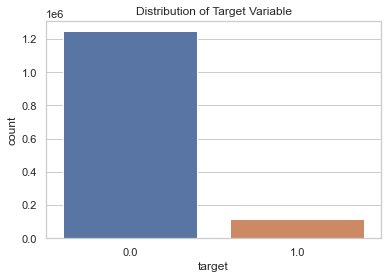

In [71]:
# Distribution of the Target Variable
sns.countplot(x='target', data=loan_applications)
plt.title('Distribution of Target Variable')
plt.show()


In [72]:
# # 2. Feature Importance using Random Forest
# features = [col for col in loan_applications.columns if col != 'target' and col != 'sk_id_curr']
# X = loan_applications[features]
# y = loan_applications['target']

# rf = RandomForestClassifier()
# rf.fit(X, y)
# importances = rf.feature_importances_
# indices = np.argsort(importances)[::-1]

# plt.figure(figsize=(15, 10))
# sns.barplot(x=X.columns[indices][:20], y=importances[indices][:20])
# plt.title('Top 20 Important Features')
# plt.xticks(rotation=45)
# plt.show()


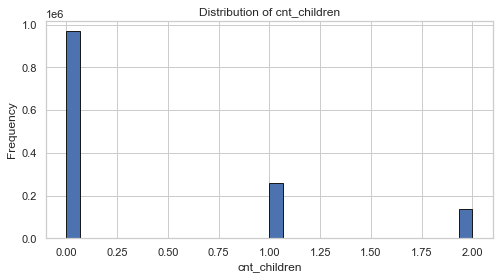

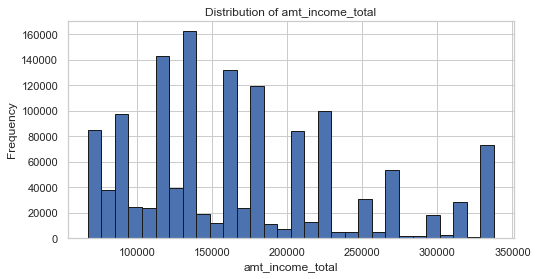

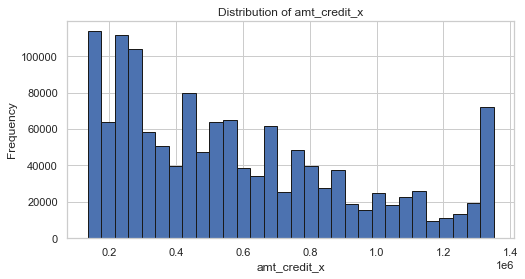

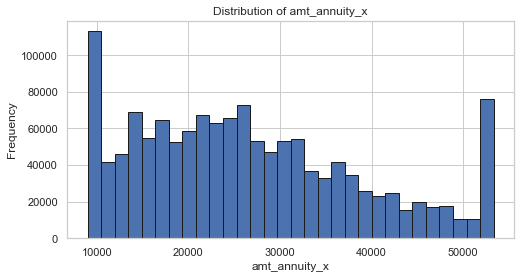

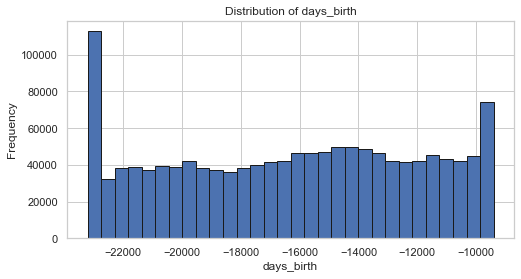

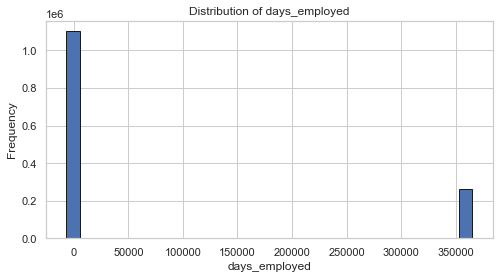

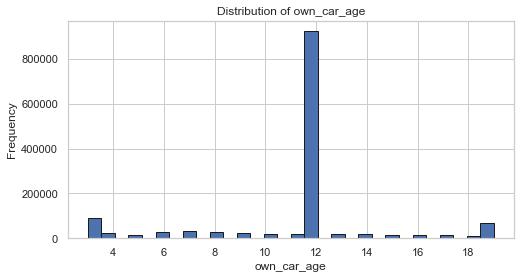

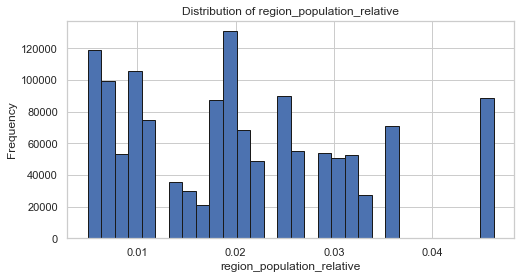

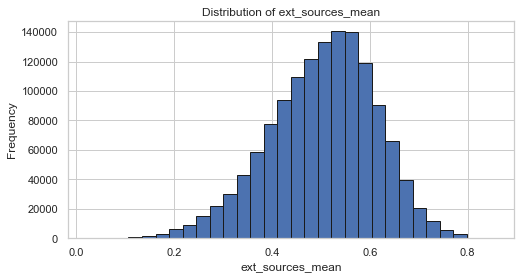

In [73]:
numerical_features = ['cnt_children', 'amt_income_total', 'amt_credit_x', 'amt_annuity_x', 'days_birth', 
                      'days_employed', 'own_car_age', 'region_population_relative', 'ext_sources_mean']

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    plt.hist(loan_applications[feature].dropna(), bins=30, edgecolor='k')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

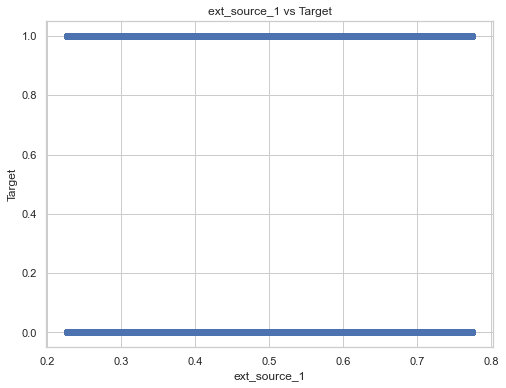

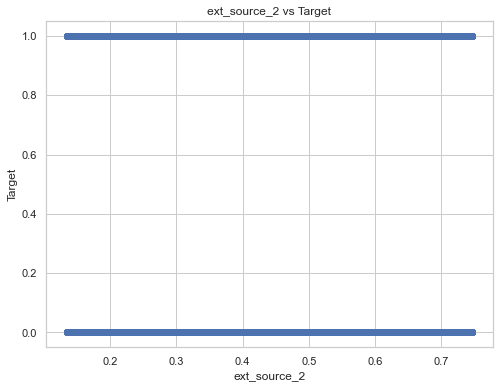

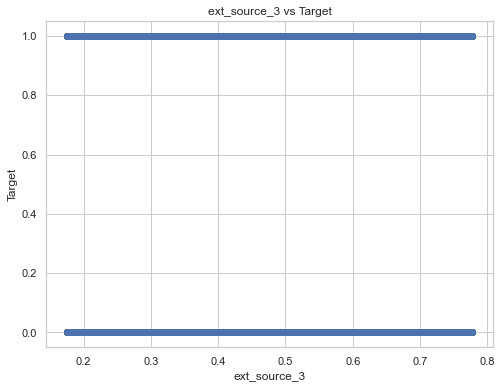

In [74]:
ext_source_features = ['ext_source_1', 'ext_source_2', 'ext_source_3']

for feature in ext_source_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(loan_applications[feature], loan_applications['target'], alpha=0.3)
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()


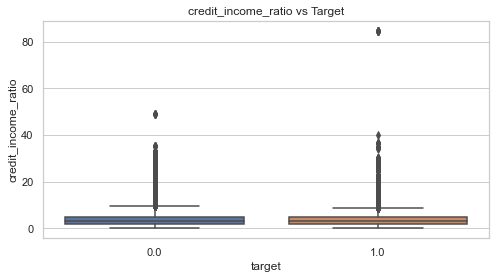

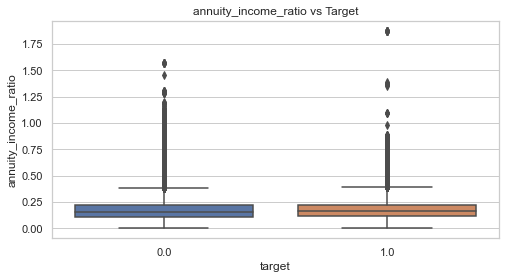

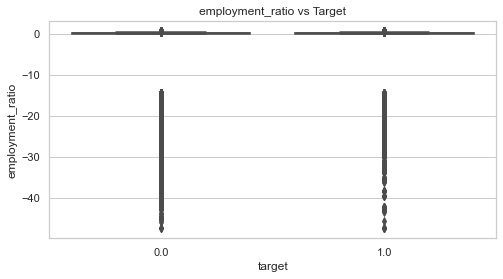

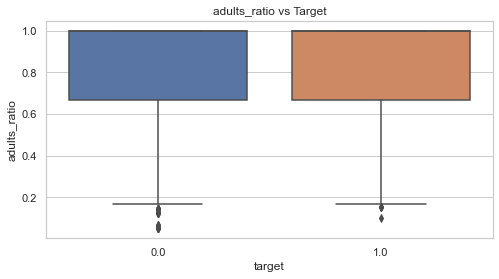

In [75]:
ratio_features = ['credit_income_ratio', 'annuity_income_ratio', 'employment_ratio', 'adults_ratio']

for feature in ratio_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='target', y=feature, data=loan_applications)
    plt.title(f'{feature} vs Target')
    plt.show()


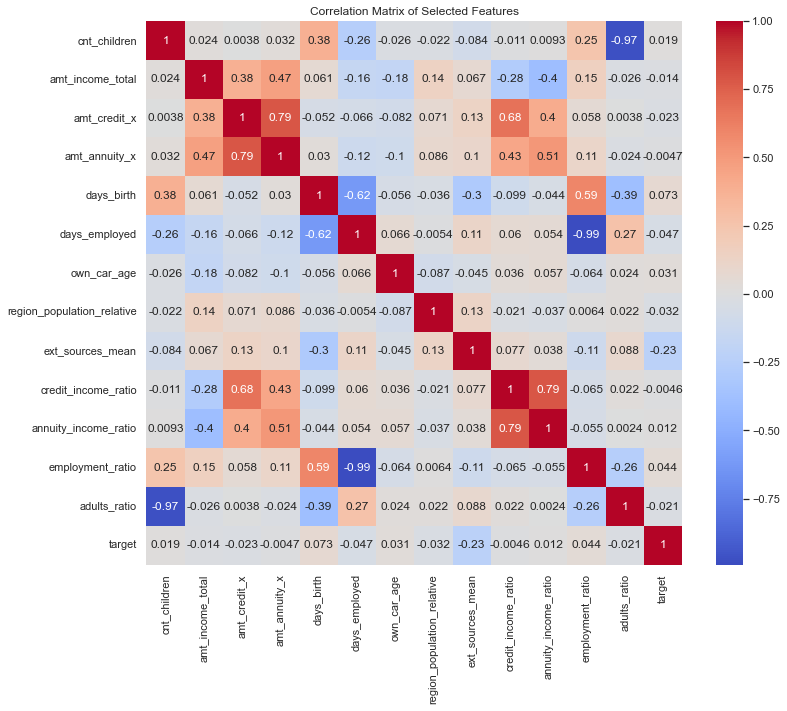

In [76]:
# Correlation with Target Variable
selected_features = numerical_features + ratio_features + ['target']
correlation_matrix = loan_applications[selected_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()


In [79]:
key_features = ['ext_sources_mean', 'credit_income_ratio', 'employment_ratio', 'amt_credit_x', 'amt_income_total']

In [81]:
# # 4. Pair Plots of Key Features

# sns.pairplot(loan_applications[key_features + ['target']], hue='target', plot_kws={'alpha': 0.5})
# plt.show()

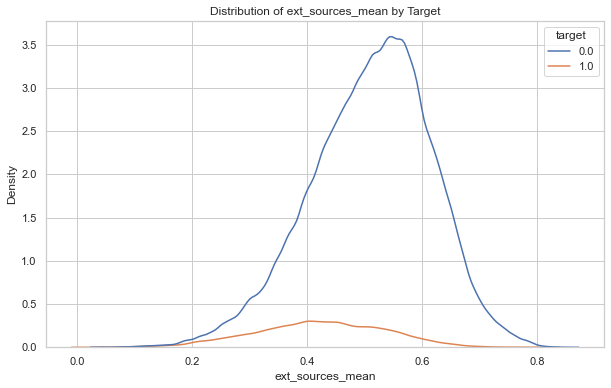

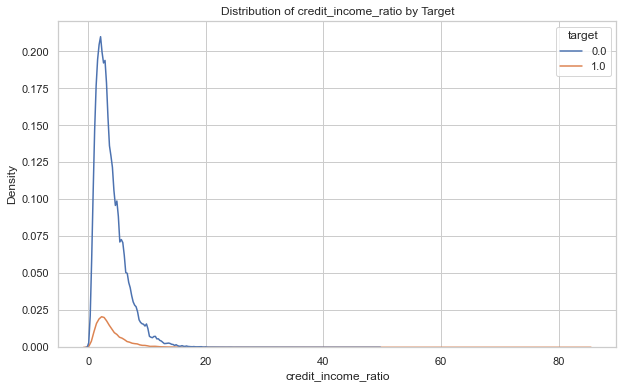

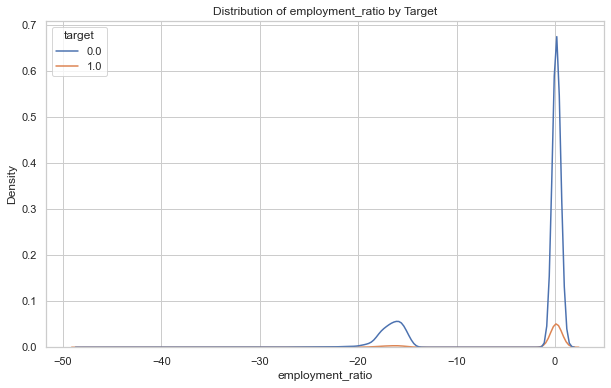

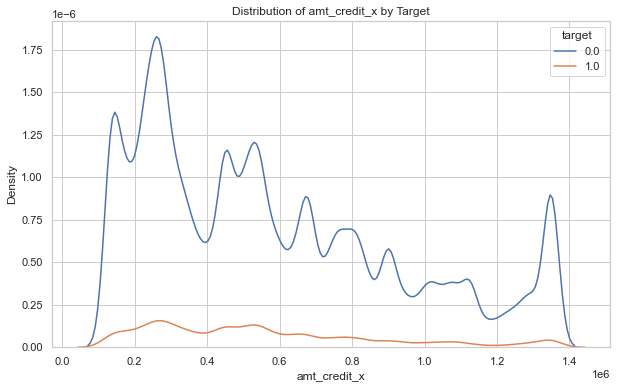

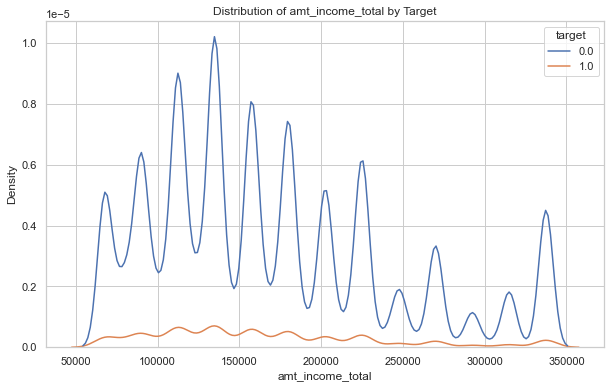

In [82]:
# 5. KDE Plots for Continuous Features
for feature in key_features:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=loan_applications, x=feature, hue='target')
    plt.title(f'Distribution of {feature} by Target')
    plt.show()

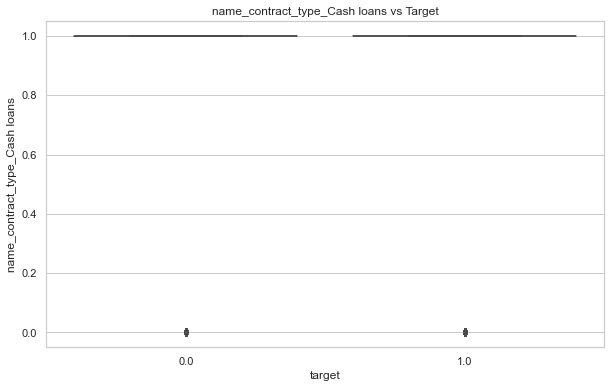

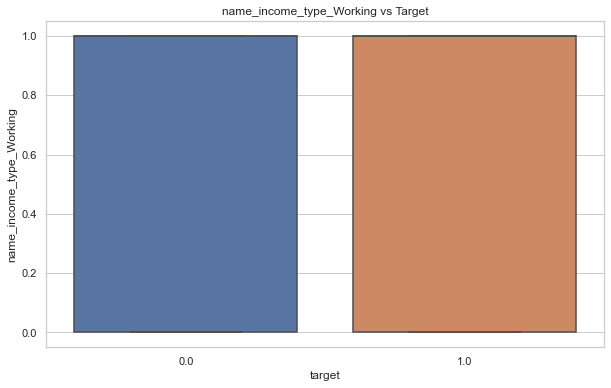

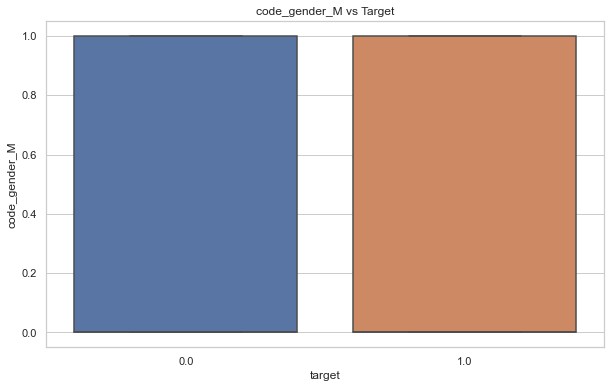

In [83]:
# 6. Box Plots for Categorical Features
categorical_features = ['name_contract_type_Cash loans', 'name_income_type_Working', 'code_gender_M']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='target', y=feature, data=loan_applications)
    plt.title(f'{feature} vs Target')
    plt.show()

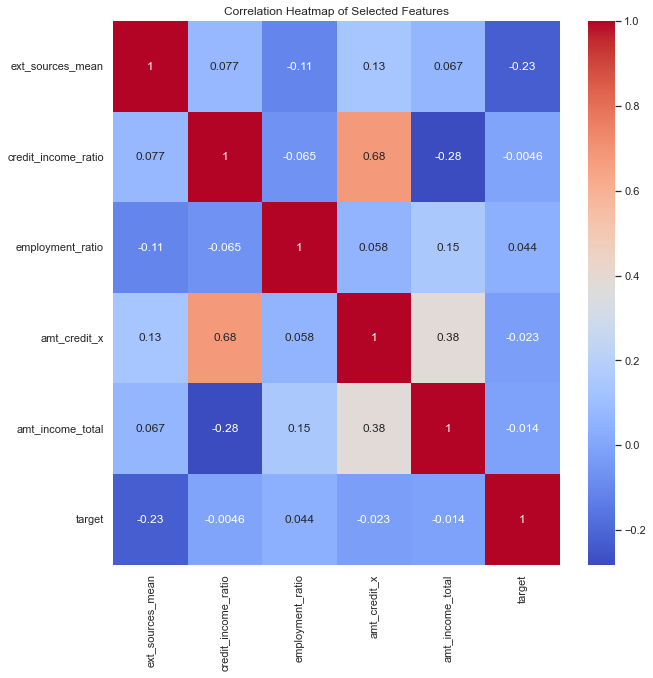

In [84]:
# 7. Heatmap of Selected Features
selected_features = key_features + ['target']
plt.figure(figsize=(10, 10))
sns.heatmap(loan_applications[selected_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()